# Nepali News Text Classification Model Evaluation

In [1]:
import os
import glob
import joblib
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    accuracy_score
)

## 1. Load and Inspect Data

In [2]:
# Load CSV files
csv_dir = '../dataset/processed'
csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))
combined_df = pd.DataFrame()

for file in csv_files:
    print(f"Loading: {file}")
    df = pd.read_csv(file)
    if not set(['category', 'text']).issubset(df.columns):
        raise ValueError(
            f"File {file} does not have required columns: ['category', 'text']")
    combined_df = pd.concat([combined_df, df], ignore_index=True)

Loading: ../dataset/processed\ArthaBanijya.csv
Loading: ../dataset/processed\Bichar.csv
Loading: ../dataset/processed\Desh.csv
Loading: ../dataset/processed\Khelkud.csv
Loading: ../dataset/processed\Manoranjan.csv
Loading: ../dataset/processed\Prabas.csv
Loading: ../dataset/processed\Sahitya.csv
Loading: ../dataset/processed\SuchanaPrabidhi.csv
Loading: ../dataset/processed\Swasthya.csv
Loading: ../dataset/processed\Viswa.csv


In [3]:
# Inspect data
print(f"Shape: {combined_df.shape}")
print(f"Missing values:\n{combined_df.isnull().sum()}")
print(f"Duplicates: {combined_df.duplicated().sum()}")
combined_df = combined_df.drop_duplicates().dropna()

Shape: (10000, 2)
Missing values:
category    0
text        0
dtype: int64
Duplicates: 4


In [4]:
# Remove duplicates and missing values
combined_df = combined_df.drop_duplicates().dropna()

<Axes: xlabel='category'>

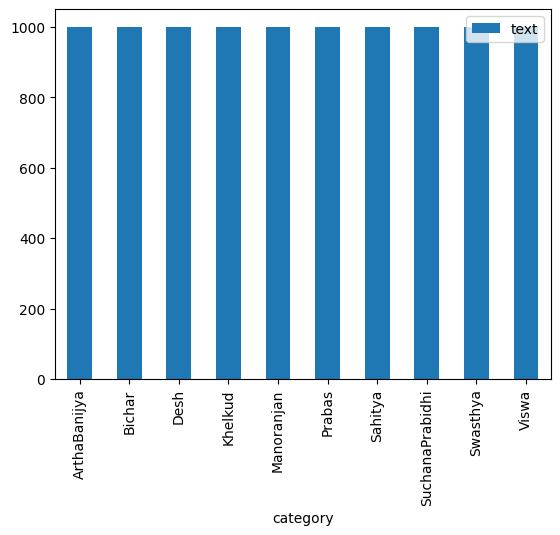

In [5]:
combined_df[["text", "category"]].groupby("category").count().plot(kind="bar")

## 2. Preprocess Data

In [6]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Move 3 levels up to the project root directory and append to sys.path
project_root = os.path.abspath(os.path.join(current_dir, '../../'))
sys.path.append(project_root)

In [7]:
from utils.preprocess import preprocess

In [8]:
tqdm.pandas()
combined_df['text'] = combined_df['text'].progress_apply(preprocess)
combined_df = combined_df[combined_df['text'].str.strip() != ""]

100%|██████████| 9996/9996 [00:07<00:00, 1310.70it/s]


In [9]:
# Map categories to numeric labels
classes = {
    label: idx
    for idx, label in enumerate(combined_df['category'].unique())
}

combined_df['target'] = combined_df['category'].map(classes)

In [10]:
classes

{'ArthaBanijya': 0,
 'Bichar': 1,
 'Desh': 2,
 'Khelkud': 3,
 'Manoranjan': 4,
 'Prabas': 5,
 'Sahitya': 6,
 'SuchanaPrabidhi': 7,
 'Swasthya': 8,
 'Viswa': 9}

In [11]:
# Split data into features and labels
X = combined_df['text']
y = combined_df['target']

In [12]:
# If X is a list of lists (tokens), join each list into a single string
X = [' '.join(doc) if isinstance(doc, list) else doc for doc in X]

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

## 3. Define Models and Hyperparameter Grids

In [14]:
param_grids = {
    'Naive Bayes': {
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier__alpha': [0.1, 0.5, 1.0]
    },
    'Logistic Regression': {
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['liblinear', 'saga']
    },
    'SVM': {
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier__C': [0.1, 1.0, 10.0],  # Regularization strength
        'classifier__kernel': ['linear', 'rbf'],  # Kernel types
        'classifier__gamma': ['scale', 'auto']  # Kernel coefficient
    }
    # 'Random Forest': {
    #     'vectorizer__ngram_range': [(1, 1), (1, 2)],
    #     'classifier__n_estimators': [100, 200],
    #     'classifier__max_depth': [None, 10, 20],
    #     'classifier__min_samples_split': [2, 5]
    # }
}

In [15]:
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    # 'Random Forest': RandomForestClassifier()
}

## 4. Train and Evaluate Models with GridSearchCV

In [16]:
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for model_name, model in models.items():
    print(f"Training {model_name}...")
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=kf,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Store results
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'model': best_model
    }

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Accuracy: {results[model_name]['accuracy']}\n")

Training Naive Bayes...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Naive Bayes: {'classifier__alpha': 0.1, 'vectorizer__ngram_range': (1, 1)}
Accuracy: 0.8215

Training Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Logistic Regression: {'classifier__C': 10.0, 'classifier__solver': 'liblinear', 'vectorizer__ngram_range': (1, 2)}
Accuracy: 0.855

Training SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

## 5. Visualize Results

In [ ]:
def plot_confusion_matrix(cm, model_name, labels):
    """
    Plot confusion matrix using seaborn

    Args:
        cm: Confusion matrix
        model_name: Name of the model
        labels: List of class labels
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels
    )
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Plot confusion matrices
for model_name, result in results.items():
    plot_confusion_matrix(
        result['confusion_matrix'],
        model_name,
        classes.keys()
    )

In [ ]:
# Performance Comparison
def plot_performance_comparison(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    scores = {metric: [] for metric in metrics}

    for model_name, result in results.items():
        for metric in metrics:
            scores[metric].append(result[metric])

    df_scores = pd.DataFrame(scores, index=results.keys())
    df_scores.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()


plot_performance_comparison(results)

## 6. Save Best Models

In [ ]:
output_dir = "../models"
os.makedirs(output_dir, exist_ok=True)

for model_name, result in results.items():
    model_name = model_name.replace(" ", "_")
    joblib.dump(result["model"], os.path.join(output_dir, f"{model_name}_classifier_model.pkl"))

    print(f"Saved {model_name} best model.")